In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
import json
import sys
from pathlib import Path
import re 

import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid
from pandas.tseries.offsets import DateOffset, BDay
from plotly import (
    io as pio,
    express as px,
    graph_objects as go,
    figure_factory as ff
)
from plotly.subplots import make_subplots

root_path = Path('/dev/projects/cds/')

if (path := str(root_path.resolve())) not in sys.path:
    sys.path.append(path)

from api.blpw import BlpQuery
from api.data.base import data_path
from api.data.curves import curves
from api.pricing.cds import get_isda_cds
from api.pricing.utils import (
    get_cds_specs,
    get_cds_curve,
    get_cds_spreads,
    get_risk_free_curve,
    get_cds_implied_price,
    get_curve,
)

import utils as u

#### User Input

In [4]:
index = 'CDX EM CDSI GEN 5Y PRC Corp'
series = [17, 37]
watch = DateOffset(weeks=2)
fn = 'mean'  # lambda x: x.quantile(.9).mean()

#### Settings

In [5]:
dt_fmt = '%Y-%m-%d'
bbg_dt_fmt = '%Y%m%d'
today = pd.Timestamp.today().floor('d')

In [6]:
options = {
    'calendarCodeOverride': '5D',
    "nonTradingDayFillOption": "ALL_CALENDAR_DAYS",
    "nonTradingDayFillMethod": "PREVIOUS_VALUE"
}

#### Bloomberg Connection

In [7]:
bq = BlpQuery(timeout=50000).start()

#### From GEN ticker to S# ticker

In [8]:
securities = [index.replace(' GEN ', f" S{i} ") for i in range(series[0], series[1] + 1)]
fields = [
    {'field': 'history_start_dt', 'name': 'issue_date'},
    {'field': 'maturity', 'name': 'maturity'},
    {'field': 'parsekeyable_description_rt', 'name': 'ticker'}
]

#### Reference download

In [9]:
ref = bq.bdp(
    securities=securities,
    fields=[field['field'] for field in fields]
).rename({field['field']: field['name'] for field in fields}, axis=1)

#### GEN history download

In [10]:
_index_hist = bq.bdh(
    securities=[index],
    fields=['px_last'],
    start_date=ref['issue_date'].min().strftime(bbg_dt_fmt),
    end_date=today.strftime(bbg_dt_fmt),
    options=options
)
index_hist = _index_hist.set_index('date')['px_last']

#### S# history download 

In [211]:
_hist = []
for index, row in ref.iterrows():
    h = bq.bdh(
        securities=[row['security']],
        fields=['px_last'],
        start_date=row['issue_date'].strftime(bbg_dt_fmt),
        end_date=min(row['maturity'], today).strftime(bbg_dt_fmt),
        options=options
    )
    _hist.append(h)

In [82]:
_hist[i]['security'][0]

'CDX EM CDSI S32 5Y PRC Corp'

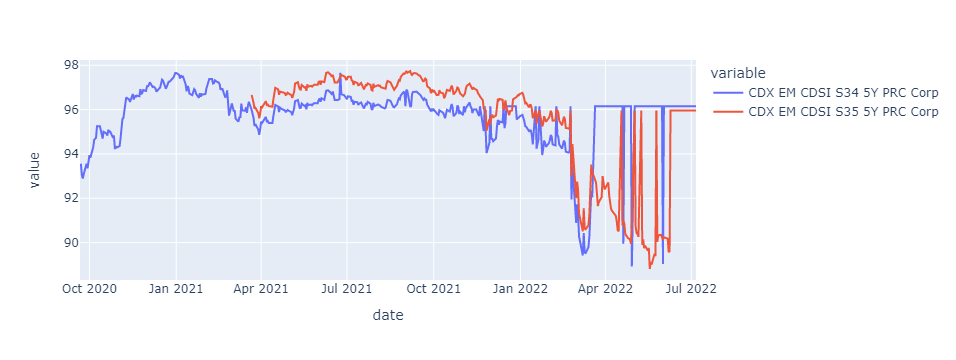

In [96]:
i = 17
pd.concat([
    _hist[i].set_index('date')['px_last'].rename(_hist[i]['security'][0]), 
    _hist[i+1].set_index('date')['px_last'].rename(_hist[i+1]['security'][0])
], axis=1).plot(backend='plotly')

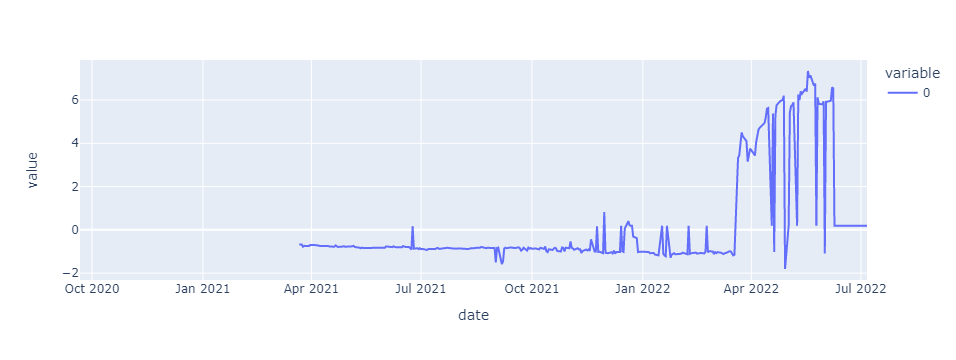

In [95]:
(_hist[i].set_index('date')['px_last'].rename(0) - _hist[i+1].set_index('date')['px_last'].rename(1)).plot(backend='plotly')

In [112]:
hist = pd.concat(_hist)

In [113]:
# hist['date'] = hist['date'].dt.tz_localize(None)
hist = hist.merge(ref.drop('ticker', axis=1), on='security')\
        .sort_values(['security', 'date'])
hist = hist.assign(roll=hist['maturity'] + DateOffset(months=6) - DateOffset(years=5, months=3))

In [115]:
group_helper = hist.groupby(['security', 'px_last',])['date'].count().groupby(['security']).idxmax()
last_traded_dates = {}
for k, v in group_helper.items():
    date = hist.query(f"security == '{v[0]}' and px_last == {v[1]}")['date'].iloc[0]
    last_traded_dates[v[0]] = date
last_traded_dates = pd.Series(last_traded_dates).rename('last_active').rename_axis('security').to_frame().reset_index()
hist = hist.merge(last_traded_dates, on='security', how='left')

#### Roll Analysis

##### Monthly

In [13]:
r = index_hist.pct_change().dropna()
g = r.groupby([r.index.year, r.index.month])
if isinstance(fn, str):
    g = getattr(g, fn)()
else:
    g = g.apply(fn)
m = g.rename_axis(['year', 'month']).reset_index().pivot(index='year', columns='month').droplevel(0, axis=1)

In [14]:
hm1 = u.heatmap(
    m, 
    fmt='.3%', 
    zmid=0,
    colorscale='RdBu',
    font_colors=[px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[0]],
    height=40 * len(m),
    width=900
)

##### Watch

In [330]:
watch_before = DateOffset(weeks=2)
watch_after = DateOffset(weeks=2)
fn = 'sum'

In [340]:
hist_chain_v2 = hist.copy()
hist_chain_v2['watch_after'] = hist_chain_v2['roll'] + watch_after
hist_chain_v2 = hist_chain_v2.loc[hist_chain_v2['date'] <= hist_chain_v2['watch_after']].drop_duplicates(subset='date')
hist_chain = hist_chain_v2.set_index('date')

In [341]:
# hist_chain = hist.loc[hist['date'] < hist['roll']].set_index('date').resample('B').ffill()
hist_chain['watch'] = (hist_chain.index >= hist_chain['roll'] - watch_before)
hist_chain['watch'] = hist_chain['watch'].replace({True: 'before', False: 'rest'})
hist_chain.loc[(hist_chain['watch_after'] < hist_chain.index + watch_after), 'watch'] = 'after'

In [342]:
rc = hist_chain.assign(ret=hist_chain['px_last'].pct_change()).dropna(subset='ret')

In [343]:
rc.to_clipboard()

In [344]:
grouper = [
    rc.index.year, 
    rc['watch']
]
gw = rc.groupby(grouper)['ret'] 
if isinstance(fn, str):
    gw = getattr(gw, fn)()
else:
    gw = gw.apply(fn)
mw = gw.reset_index().pivot(index='date', columns='watch').droplevel(0, axis=1)

In [347]:
hm2 = u.heatmap(
    mw, 
    fmt='.3%', 
    zmid=0,
    colorscale='RdBu',
    font_colors=[px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[0]],
    height=40 * len(mw),
    width=350
)

In [348]:
grouper = [
    rc.index.year,
    rc['roll'].dt.month,
    rc['watch']
]
gw = rc.groupby(grouper)['ret'] 
if isinstance(fn, str):
    gw = getattr(gw, fn)()
else:
    gw = gw.apply(fn)
mw = gw.reset_index().pivot(index=['date'], columns=['watch', 'roll']).droplevel(0, axis=1).sort_index(level=[1, 0], axis=1)

In [349]:
hm3 = u.heatmap(
    mw.set_axis(['_'.join([str(i) for i in c]) for c in mw.columns], axis=1), 
    fmt='.3%', 
    zmid=0,
    colorscale='RdBu',
    font_colors=[px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[0]],
    height=40 * len(mw),
    width=700
)

In [350]:
w.HBox([go.FigureWidget(hm2),go.FigureWidget(hm3)])

C:\dev\projects\cds\venv\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
  …

In [79]:
fig = hist_chain['px_last'].plot(height=500, backend='plotly')
fig = u.add_vlines(fig,  hist_chain['watch'] == 'before')
fig = u.add_vlines(fig,  hist_chain['watch'] == 'after', line_color='red')

#### Plot

In [22]:
w.VBox(
    [
        go.FigureWidget(fig),
        w.HBox(
            [
                go.FigureWidget(hm1),
                go.FigureWidget(hm2)
            ]
        )
    ]
)

C:\dev\projects\cds\venv\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



    'data': [{'hovertemplate': 'variable=px_last<br>date=%{x}<br>value=%{y}<extr…